In [ ]:
###IS JAM MODEL####

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the model-ready dataset
df = pd.read_csv("traffic_with_weather_modified.csv")

# Convert datetime column to datetime objects
df['datetime'] = pd.to_datetime(df['datetime'])

df.head()

,datetime,bendahara_motorcycle,bendahara_car,bendahara_truck,bendahara_bus,bendahara_total,temenggong_motorcycle,temenggong_car,temenggong_truck,temenggong_bus,...,is_holiday_mlk,is_holiday,is_jam,car_share,motorcycle_share,truck_share,bus_share,peak_category,day_of_week,month
0,2024-01-01 00:00:00,25,225,0,0,250,52,66,0,0,...,True,True,False,0.790761,0.209239,0.00000,0.0,Off-Peak,Monday,January
1,2024-01-01 01:00:00,42,216,0,0,258,60,75,0,0,...,True,True,False,0.740458,0.259542,0.00000,0.0,Off-Peak,Monday,January
2,2024-01-01 02:00:00,30,221,0,0,251,131,162,0,0,...,True,True,False,0.704044,0.295956,0.00000,0.0,Off-Peak,Monday,January
3,2024-01-01 03:00:00,36,218,0,0,254,54,69,0,0,...,True,True,False,0.761273,0.238727,0.00000,0.0,Off-Peak,Monday,January
4,2024-01-01 04:00:00,46,213,0,0,259,67,88,1,0,...,True,True,False,0.725301,0.272289,0.00241,0.0,Off-Peak,Monday,January


In [11]:
# --- Define Target (y) ---
y = df['is_jam']

# --- Define Features (X) ---
# We select only the features a user would know ahead of time (time, day, weather)
# We exclude data-leaking columns (like total_traffic) and identifiers.
features_to_use = [
    'temperature_2m', 
    'relative_humidity_2m', 
    'weathercode', 
    'windspeed_10m',
    'is_weekend', 
    'hour', 
    'is_holiday_mlk',
    'day_of_week',
    'month'
]

X = df[features_to_use]

print("Our target variable (y):")
print(y.head())
print("\nOur features (X) for the model:")
print(X.head())

Our target variable (y):
0    False
1    False
2    False
3    False
4    False
Name: is_jam, dtype: bool

Our features (X) for the model:
   temperature_2m  relative_humidity_2m  weathercode  windspeed_10m  \
0            25.3                    92            3            5.9   
1            25.0                    91            3            6.3   
2            24.7                    93            1            7.5   
3            24.5                    94            2            8.4   
4            24.3                    94            2            9.7   

   is_weekend  hour  is_holiday_mlk day_of_week    month  
0       False     0            True      Monday  January  
1       False     1            True      Monday  January  
2       False     2            True      Monday  January  
3       False     3            True      Monday  January  
4       False     4            True      Monday  January  


In [13]:
# --- Create Cyclical Features for Time ---
# This helps the model understand the cyclical nature of hours and months
X['hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
X['hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)

# We need to convert month names to numbers first
month_map = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 
             'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}
X['month_num'] = X['month'].map(month_map)

X['month_sin'] = np.sin(2 * np.pi * X['month_num'] / 12)
X['month_cos'] = np.cos(2 * np.pi * X['month_num'] / 12)

# Now we can drop the original hour and month columns
X = X.drop(['hour', 'month', 'month_num'], axis=1)


# --- Define Categorical and Numerical Features for Preprocessing ---
categorical_features = ['day_of_week', 'weathercode']
numerical_features = ['temperature_2m', 'relative_humidity_2m', 'windspeed_10m', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']

# Create a preprocessor object
# It will scale numerical data and one-hot encode categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns (like is_weekend, is_holiday_mlk) as they are
)

# Apply the preprocessing to our feature set X
X_processed = preprocessor.fit_transform(X)

print("\nShape of our processed features:", X_processed.shape)
print("The data is now fully numerical and ready for the model!")


Shape of our processed features: (8782, 26)
The data is now fully numerical and ready for the model!


C:\Users\syahm\AppData\Local\Temp\ipykernel_2596\1210235725.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
C:\Users\syahm\AppData\Local\Temp\ipykernel_2596\1210235725.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)
C:\Users\syahm\AppData\Local\Temp\ipykernel_2596\1210235725.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [15]:
# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # 'stratify=y' ensures the same proportion of jams/non-jams in both sets
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training set shape: (7025, 26)
Testing set shape: (1757, 26)
Training labels shape: (7025,)
Testing labels shape: (1757,)


In [17]:
# --- Model 1: Logistic Regression ---

# Initialize the model
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Train the model on the training data
print("Training the Logistic Regression model...")
log_reg.fit(X_train, y_train)
print("Training complete!")

# Make predictions on the test set
y_pred_lr = log_reg.predict(X_test)

Training the Logistic Regression model...
Training complete!


In [19]:
# --- Model 2: Random Forest Classifier ---

# Initialize the model
# We can start with some sensible defaults. n_estimators is the number of trees.
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model on the training data
print("\nTraining the Random Forest model...")
rf_clf.fit(X_train, y_train)
print("Training complete!")

# Make predictions on the test set
y_pred_rf = rf_clf.predict(X_test)


Training the Random Forest model...
Training complete!


--- Logistic Regression - Evaluation ---
Accuracy: 0.7980

Classification Report:
              precision    recall  f1-score   support

   Not a Jam       0.80      0.99      0.89      1405
         Jam       0.38      0.01      0.03       352

    accuracy                           0.80      1757
   macro avg       0.59      0.50      0.46      1757
weighted avg       0.72      0.80      0.71      1757

Confusion Matrix:


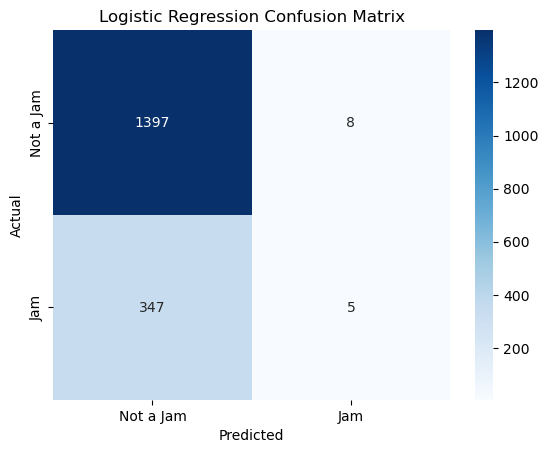

In [21]:
# --- Evaluate Model 1: Logistic Regression ---

print("--- Logistic Regression - Evaluation ---")

# 1. Accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy_lr:.4f}\n")

# 2. Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Not a Jam', 'Jam']))

# 3. Confusion Matrix
print("Confusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Not a Jam', 'Jam'], yticklabels=['Not a Jam', 'Jam'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Logistic Regression Confusion Matrix')
plt.show()


--- Random Forest - Evaluation ---
Accuracy: 0.8463

Classification Report:
              precision    recall  f1-score   support

   Not a Jam       0.87      0.95      0.91      1405
         Jam       0.68      0.45      0.54       352

    accuracy                           0.85      1757
   macro avg       0.77      0.70      0.72      1757
weighted avg       0.83      0.85      0.83      1757

Confusion Matrix:


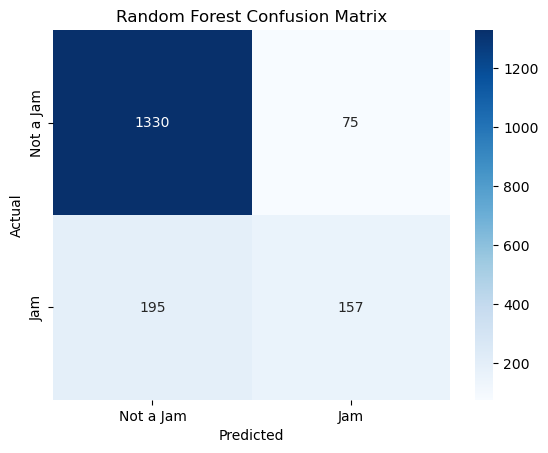

In [23]:
# --- Evaluate Model 2: Random Forest Classifier ---

print("\n--- Random Forest - Evaluation ---")

# 1. Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf:.4f}\n")

# 2. Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Not a Jam', 'Jam']))

# 3. Confusion Matrix
print("Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Not a Jam', 'Jam'], yticklabels=['Not a Jam', 'Jam'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Random Forest Confusion Matrix')
plt.show()


--- Top 10 Most Important Features for Predicting Jams ---
                 feature  importance
2          windspeed_10m    0.139043
0         temperature_2m    0.130818
6              month_cos    0.126777
5              month_sin    0.121332
1   relative_humidity_2m    0.116853
4               hour_cos    0.092254
3               hour_sin    0.079109
17         weathercode_3    0.018079
24            is_weekend    0.015779
18        weathercode_51    0.015603


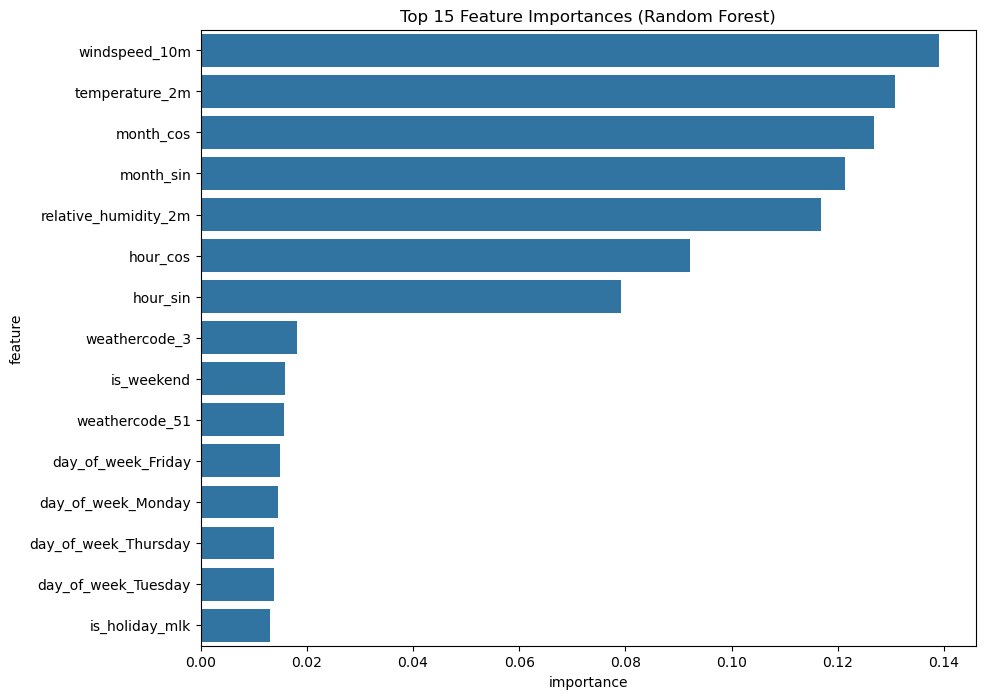

In [25]:
# --- Get Feature Names from the Preprocessor ---
# This is a bit complex, but it's to get the correct column names after one-hot encoding
try:
    ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = numerical_features + ohe_feature_names.tolist() + ['is_weekend', 'is_holiday_mlk']
except AttributeError: # Fallback for older scikit-learn versions
    ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names(categorical_features)
    all_feature_names = numerical_features + list(ohe_feature_names) + ['is_weekend', 'is_holiday_mlk']


# --- Create a DataFrame for Feature Importances ---
importances = pd.DataFrame({
    'feature': all_feature_names,
    'importance': rf_clf.feature_importances_
}).sort_values('importance', ascending=False)

# Display the top 10 most important features
print("\n--- Top 10 Most Important Features for Predicting Jams ---")
print(importances.head(10))

# --- Plot the Feature Importances ---
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importances.head(15))
plt.title('Top 15 Feature Importances (Random Forest)')
plt.show()


In [27]:
# You might need to install this library first. 
# In your terminal or a new cell, run: pip install imblearn
from imblearn.over_sampling import SMOTE

# --- Apply SMOTE to the Training Data ONLY ---
print("Original training data class distribution:")
print(y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nResampled (SMOTE) training data class distribution:")
print(y_train_resampled.value_counts())

Original training data class distribution:
is_jam
False    5620
True     1405
Name: count, dtype: int64


C:\Users\syahm\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\syahm\anaconda3\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(



Resampled (SMOTE) training data class distribution:
is_jam
False    5620
True     5620
Name: count, dtype: int64


In [29]:
# --- Retrain Model 2: Random Forest on SMOTE Data ---

# Initialize a new model (or you can reuse the old one)
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model on the RESAMPLED training data
print("\nTraining the Random Forest model on SMOTE data...")
rf_smote.fit(X_train_resampled, y_train_resampled)
print("Training complete!")

# Make predictions on the ORIGINAL, UNSEEN test set
y_pred_rf_smote = rf_smote.predict(X_test)


Training the Random Forest model on SMOTE data...
Training complete!



--- Random Forest with SMOTE - Evaluation ---
Accuracy: 0.8480

Classification Report:
              precision    recall  f1-score   support

   Not a Jam       0.89      0.92      0.91      1405
         Jam       0.63      0.57      0.60       352

    accuracy                           0.85      1757
   macro avg       0.76      0.74      0.75      1757
weighted avg       0.84      0.85      0.84      1757

Confusion Matrix:


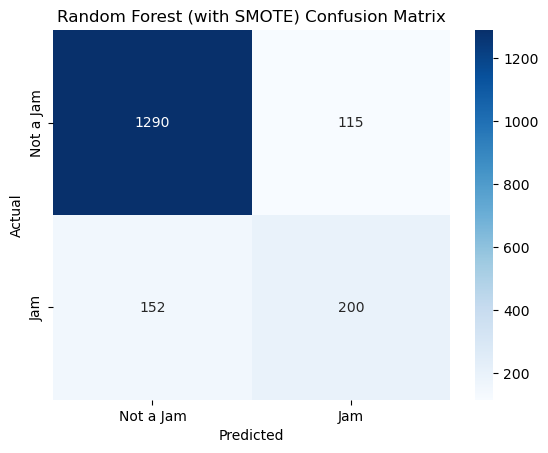

In [31]:
# --- Evaluate Model 2 (SMOTE version) ---

print("\n--- Random Forest with SMOTE - Evaluation ---")

# 1. Accuracy
accuracy_rf_smote = accuracy_score(y_test, y_pred_rf_smote)
print(f"Accuracy: {accuracy_rf_smote:.4f}\n")

# 2. Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_rf_smote, target_names=['Not a Jam', 'Jam']))

# 3. Confusion Matrix
print("Confusion Matrix:")
cm_rf_smote = confusion_matrix(y_test, y_pred_rf_smote)
sns.heatmap(cm_rf_smote, annot=True, fmt='d', cmap='Blues', xticklabels=['Not a Jam', 'Jam'], yticklabels=['Not a Jam', 'Jam'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Random Forest (with SMOTE) Confusion Matrix')
plt.show()

--- Top 10 Most Important Features for Predicting Jams (SMOTE Model) ---
                 feature  importance
6              month_cos    0.153807
5              month_sin    0.152053
4               hour_cos    0.147643
3               hour_sin    0.104203
2          windspeed_10m    0.089014
0         temperature_2m    0.088688
1   relative_humidity_2m    0.085518
17         weathercode_3    0.016965
11  day_of_week_Thursday    0.016444
18        weathercode_51    0.015212


C:\Users\syahm\AppData\Local\Temp\ipykernel_2596\1231316653.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importances.head(15), palette='viridis')


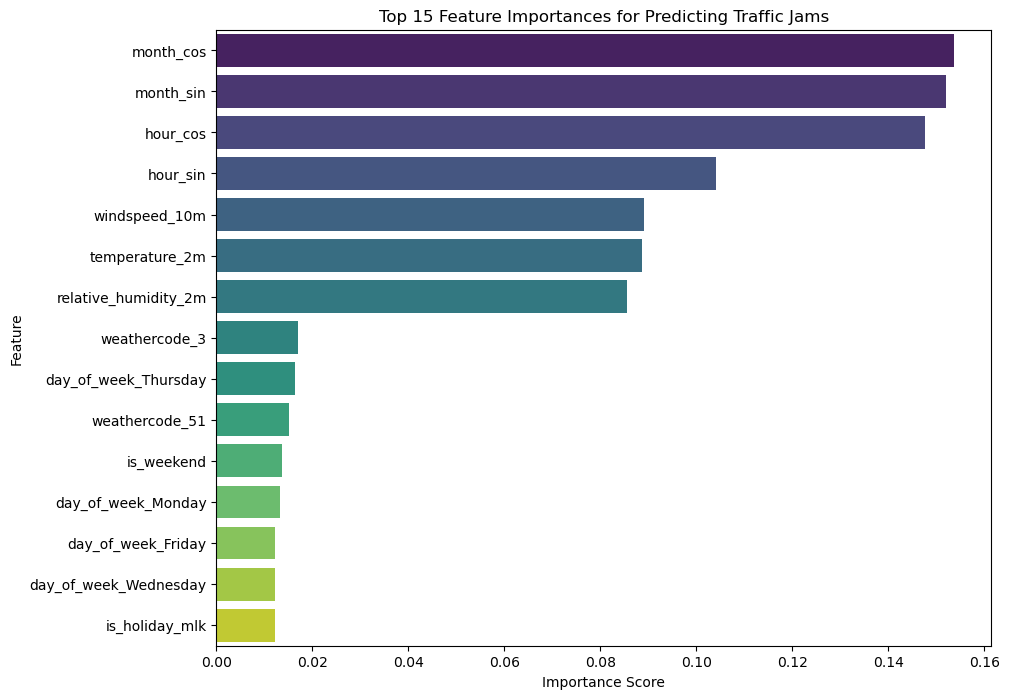

In [33]:
# --- Get Feature Names from the Preprocessor ---
# We use the same code as before to get the correct feature names after one-hot encoding.
try:
    # For newer versions of scikit-learn
    categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
except AttributeError:
    # Fallback for older versions
    categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names(categorical_features)

# Combine all feature names in the correct order
all_feature_names = numerical_features + list(categorical_feature_names) + ['is_weekend', 'is_holiday_mlk']


# --- Create a DataFrame for Feature Importances from the SMOTE model ---
importances = pd.DataFrame({
    'feature': all_feature_names,
    'importance': rf_smote.feature_importances_
}).sort_values('importance', ascending=False)

# Display the top 10 most important features
print("--- Top 10 Most Important Features for Predicting Jams (SMOTE Model) ---")
print(importances.head(10))


# --- Plot the Feature Importances for better visualization ---
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importances.head(15), palette='viridis')
plt.title('Top 15 Feature Importances for Predicting Traffic Jams')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [35]:
# The features (X) and the preprocessing steps are exactly the same as before.
# We can reuse the X_processed, X_train, and X_test variables.

# --- Define the NEW Target Variable (y) ---
# This time, our target is the 'peak_category' column.
y_peak = df['peak_category']

# --- Display the class distribution to check for imbalance ---
print("Class distribution for 'peak_category':")
print(y_peak.value_counts())

Class distribution for 'peak_category':
peak_category
Peak        4026
Shoulder    2926
Off-Peak    1830
Name: count, dtype: int64


In [37]:
# Split the new target variable y_peak into training and testing sets
# We use the same test_size and random_state to ensure the splits align with our X sets.
X_train_peak, X_test_peak, y_train_peak, y_test_peak = train_test_split(
    X_processed, 
    y_peak, 
    test_size=0.2, 
    random_state=42,
    stratify=y_peak # Stratify ensures each category is proportionally represented
)

print(f"\nShape of the training set for peak model: {X_train_peak.shape}")
print(f"Shape of the testing set for peak model: {X_test_peak.shape}")


Shape of the training set for peak model: (7025, 26)
Shape of the testing set for peak model: (1757, 26)


In [39]:
# --- Apply SMOTE to the new training data ---
print("\nOriginal training data class distribution for peak_category:")
print(y_train_peak.value_counts())

# Initialize SMOTE. It works for multi-class problems automatically.
smote_peak = SMOTE(random_state=42)
X_train_resampled_peak, y_train_resampled_peak = smote_peak.fit_resample(X_train_peak, y_train_peak)

print("\nResampled (SMOTE) training data class distribution for peak_category:")
print(y_train_resampled_peak.value_counts())


Original training data class distribution for peak_category:
peak_category
Peak        3220
Shoulder    2341
Off-Peak    1464
Name: count, dtype: int64

Resampled (SMOTE) training data class distribution for peak_category:
peak_category
Peak        3220
Off-Peak    3220
Shoulder    3220
Name: count, dtype: int64


C:\Users\syahm\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\syahm\anaconda3\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [41]:
# --- Train the Random Forest model for multi-class classification ---

# Initialize the model
rf_peak = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model on the RESAMPLED data for the peak category
print("\nTraining the Random Forest model for peak_category...")
rf_peak.fit(X_train_resampled_peak, y_train_resampled_peak)
print("Training complete!")

# Make predictions on the ORIGINAL, UNSEEN test set
y_pred_peak = rf_peak.predict(X_test_peak)


Training the Random Forest model for peak_category...
Training complete!



--- Random Forest for Peak Category - Evaluation ---
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

    Off-Peak       1.00      1.00      1.00       366
        Peak       1.00      1.00      1.00       806
    Shoulder       1.00      1.00      1.00       585

    accuracy                           1.00      1757
   macro avg       1.00      1.00      1.00      1757
weighted avg       1.00      1.00      1.00      1757

Confusion Matrix:


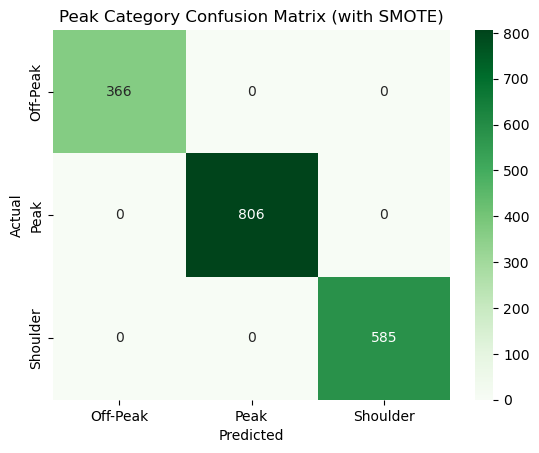

In [43]:
# --- Evaluate the peak_category model ---

print("\n--- Random Forest for Peak Category - Evaluation ---")

# 1. Accuracy
accuracy_peak = accuracy_score(y_test_peak, y_pred_peak)
print(f"Accuracy: {accuracy_peak:.4f}\n")

# 2. Classification Report
# We provide the class names in the correct order for the report labels
class_names = ['Off-Peak', 'Peak', 'Shoulder']
print("Classification Report:")
print(classification_report(y_test_peak, y_pred_peak, labels=class_names))

# 3. Confusion Matrix
print("Confusion Matrix:")
cm_peak = confusion_matrix(y_test_peak, y_pred_peak, labels=class_names)
sns.heatmap(cm_peak, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Peak Category Confusion Matrix (with SMOTE)')
plt.show()

In [47]:
# --- Define Target (y) ---
y_peak = df['peak_category']

# --- Define Features (X) - CORRECTED LIST ---
# We use only the features a user would know ahead of time (time, day, weather)
# This list is now IDENTICAL to the one we used for the is_jam model.
features_to_use = [
    'temperature_2m', 
    'relative_humidity_2m', 
    'weathercode', 
    'windspeed_10m',
    'is_weekend', 
    'hour', 
    'is_holiday_mlk',
    'day_of_week',
    'month'
]

X = df[features_to_use]

In [49]:
# --- Create Cyclical Features ---
X['hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
X['hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)
month_map = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 
             'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}
X['month_num'] = X['month'].map(month_map)
X['month_sin'] = np.sin(2 * np.pi * X['month_num'] / 12)
X['month_cos'] = np.cos(2 * np.pi * X['month_num'] / 12)
X = X.drop(['hour', 'month', 'month_num'], axis=1)

# --- Define Categorical and Numerical Features ---
categorical_features = ['day_of_week', 'weathercode']
numerical_features = ['temperature_2m', 'relative_humidity_2m', 'windspeed_10m', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']

# --- Create and Apply Preprocessor ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)
X_processed = preprocessor.fit_transform(X)

# --- Split the data ---
X_train_peak, X_test_peak, y_train_peak, y_test_peak = train_test_split(
    X_processed, y_peak, test_size=0.2, random_state=42, stratify=y_peak)

# --- Apply SMOTE ---
smote_peak = SMOTE(random_state=42)
X_train_resampled_peak, y_train_resampled_peak = smote_peak.fit_resample(X_train_peak, y_train_peak)

C:\Users\syahm\AppData\Local\Temp\ipykernel_2596\743307270.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
C:\Users\syahm\AppData\Local\Temp\ipykernel_2596\743307270.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)
C:\Users\syahm\AppData\Local\Temp\ipykernel_2596\743307270.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [51]:
# --- Re-train the model ---
rf_peak = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
print("\nRe-training the Random Forest model for peak_category...")
rf_peak.fit(X_train_resampled_peak, y_train_resampled_peak)
print("Training complete!")

# --- Re-evaluate ---
y_pred_peak = rf_peak.predict(X_test_peak)
print("\n--- Random Forest for Peak Category - CORRECTED Evaluation ---\n")
print(classification_report(y_test_peak, y_pred_peak, labels=sorted(y_peak.unique())))


Re-training the Random Forest model for peak_category...
Training complete!

--- Random Forest for Peak Category - CORRECTED Evaluation ---

              precision    recall  f1-score   support

    Off-Peak       1.00      1.00      1.00       366
        Peak       1.00      1.00      1.00       806
    Shoulder       1.00      1.00      1.00       585

    accuracy                           1.00      1757
   macro avg       1.00      1.00      1.00      1757
weighted avg       1.00      1.00      1.00      1757

